In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import h5py
import scanpy as sc
import anndata
import gc
import pickle
from einops import rearrange
import matplotlib.pyplot as plt

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error

In [4]:
# %pip install scanpy
# %pip install anndata
# %pip install lightgbm
# %pip install numpy scikit-learn

# Load data 

In [3]:
DATA_DIR = "/home/wuxinchao/data/project/kaggle_comp_scmo_data/data"
CELL_METADATA = os.path.join(DATA_DIR, "metadata.csv")
CITE_TRAIN_INPUTS = os.path.join(DATA_DIR, "train_cite_inputs.h5")
CITE_TRAIN_TARGETS = os.path.join(DATA_DIR, "train_cite_targets.h5")
CITE_TEST_INPUTS = os.path.join(DATA_DIR, "test_cite_inputs.h5")

MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR, "train_multi_inputs.h5")
MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR, "train_multi_targets.h5")
MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR, "test_multi_inputs.h5")

SUBMISSION = os.path.join(DATA_DIR, "sample_submission.csv")
EVALUATION_IDS = os.path.join(DATA_DIR, "evaluation_ids.csv")

In [4]:
df_cell = pd.read_csv(CELL_METADATA)
df_cell_cite = df_cell[df_cell.technology=="citeseq"]
df_cell_multi = df_cell[df_cell.technology=="multiome"]
df_cell_cite.shape, df_cell_multi.shape

((119651, 5), (161877, 5))

In [5]:
# check dsb and centered log-ration for normalization of protein data

df_cell_cite.columns

Index(['cell_id', 'day', 'donor', 'cell_type', 'technology'], dtype='object')

# Preprocess for CITEseq

In [6]:
%%time

col_start = 10000

class PreprocessCiteseq(BaseEstimator, TransformerMixin):
    columns_to_use = 13000

    @staticmethod
    def take_column_subset(X):
        return X[:, -(PreprocessCiteseq.columns_to_use + col_start):-col_start]
    
    def transform(self, X):
        print(X.shape)
        X = X[:, ~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X)
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X
    
    def fit_transform(self, X):
        gc.collect()
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:, ~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X)
        print(X.shape)
        gc.collect()

        self.pca = PCA(n_components=240, copy=False, random_state=1)
        X = self.pca.fit_transform(X)
        print(X.shape)
        return X

preprocesser = PreprocessCiteseq()
cite_train_x = None
cite_train_x = preprocesser.fit_transform(pd.read_hdf(CITE_TRAIN_INPUTS).values)

cite_train_y = pd.read_hdf(CITE_TRAIN_TARGETS).values
print(cite_train_x.shape, cite_train_y.shape)

(70988, 22050)
(70988, 21601)
(70988, 11601)
(70988, 240)
(70988, 240) (70988, 140)
CPU times: user 16min 38s, sys: 7min 56s, total: 24min 35s
Wall time: 1min 30s


In [7]:
# check the distribution of the protein data
# get the cell id and protein id of the citeseq data
cite_train_y = pd.read_hdf(CITE_TRAIN_TARGETS)
print(cite_train_y.columns) # the protein id
print(cite_train_y.index) # the cell id

Index(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', name='gene_id', length=140)
Index(['45006fe3e4c8', 'd02759a80ba2', 'c016c6b0efa5', 'ba7f733a4f75',
       'fbcf2443ffb2', 'd80d84ca8e89', '1ac2049b4c98', '33fb0c29e2e4',
       'b329261bd0ee', '703762287e88',
       ...
       'f901120ab887', 'e3780c598532', '663da056425f', '10b466d6898b',
       '4d22a430b2b8', '650ee456f0f3', 'cc506e7707f5', 'a91f1b55a520',
       '3a9882c98205', 'c91b6b2ccd3d'],
      dtype='object', name='cell_id', length=70988)


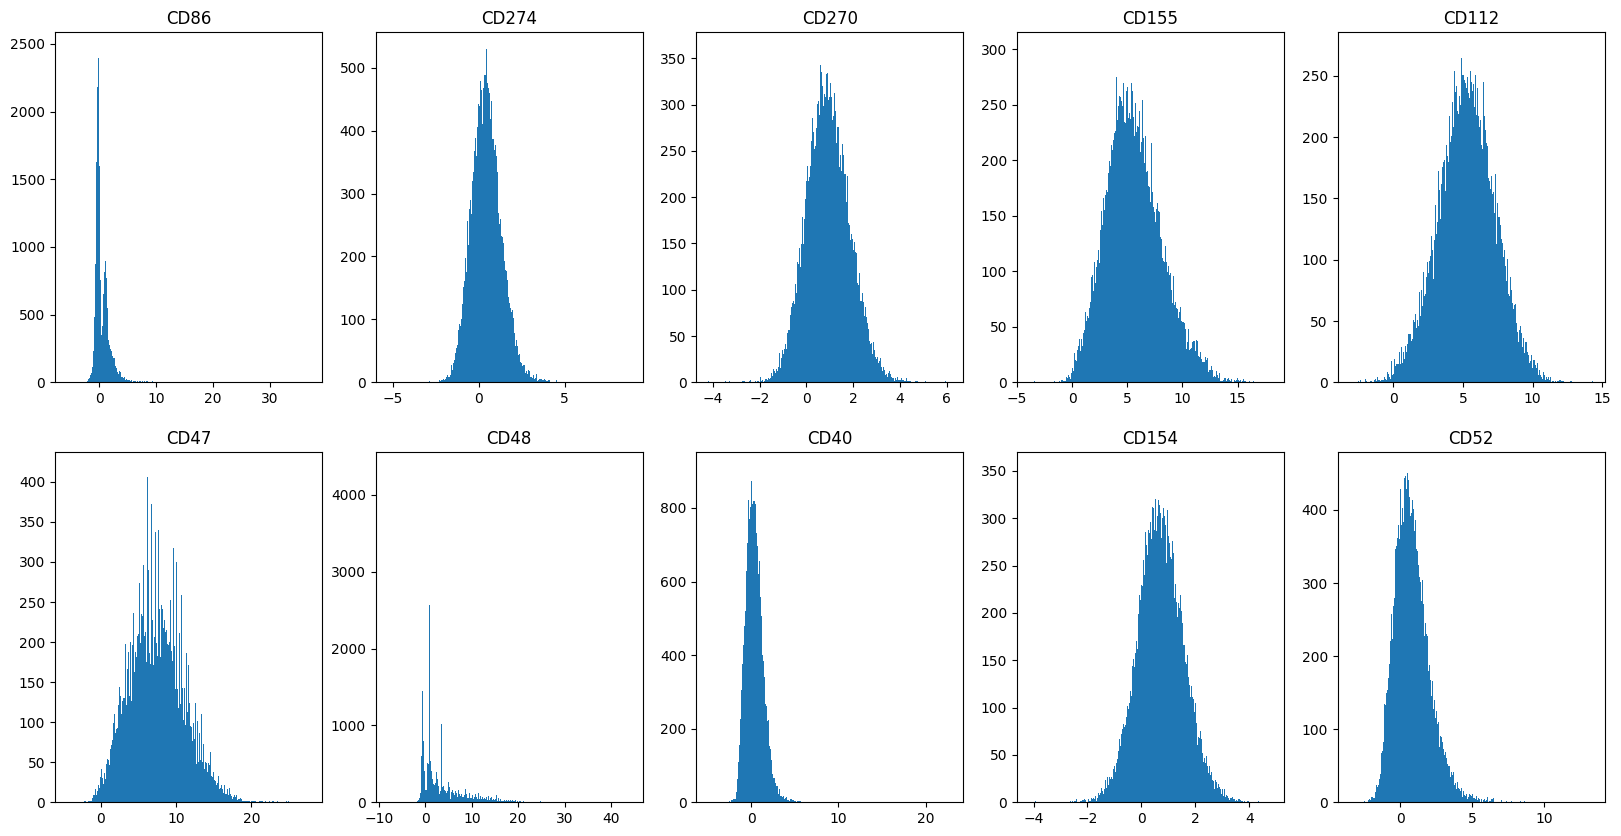

In [8]:
# show the distribution of the protein data of CD86
# CD86_expression = cite_train_y['CD86']
# plt.hist(CD86_expression, bins=1000)
# plt.show()

# show the distribution of the first 10 protein data
# the plots are subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    axs[i//5, i%5].hist(cite_train_y[cite_train_y.columns[i]], bins=1000)
    axs[i//5, i%5].set_title(cite_train_y.columns[i])
plt.show()

/home/wuxinchao/.conda/envs/torch/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


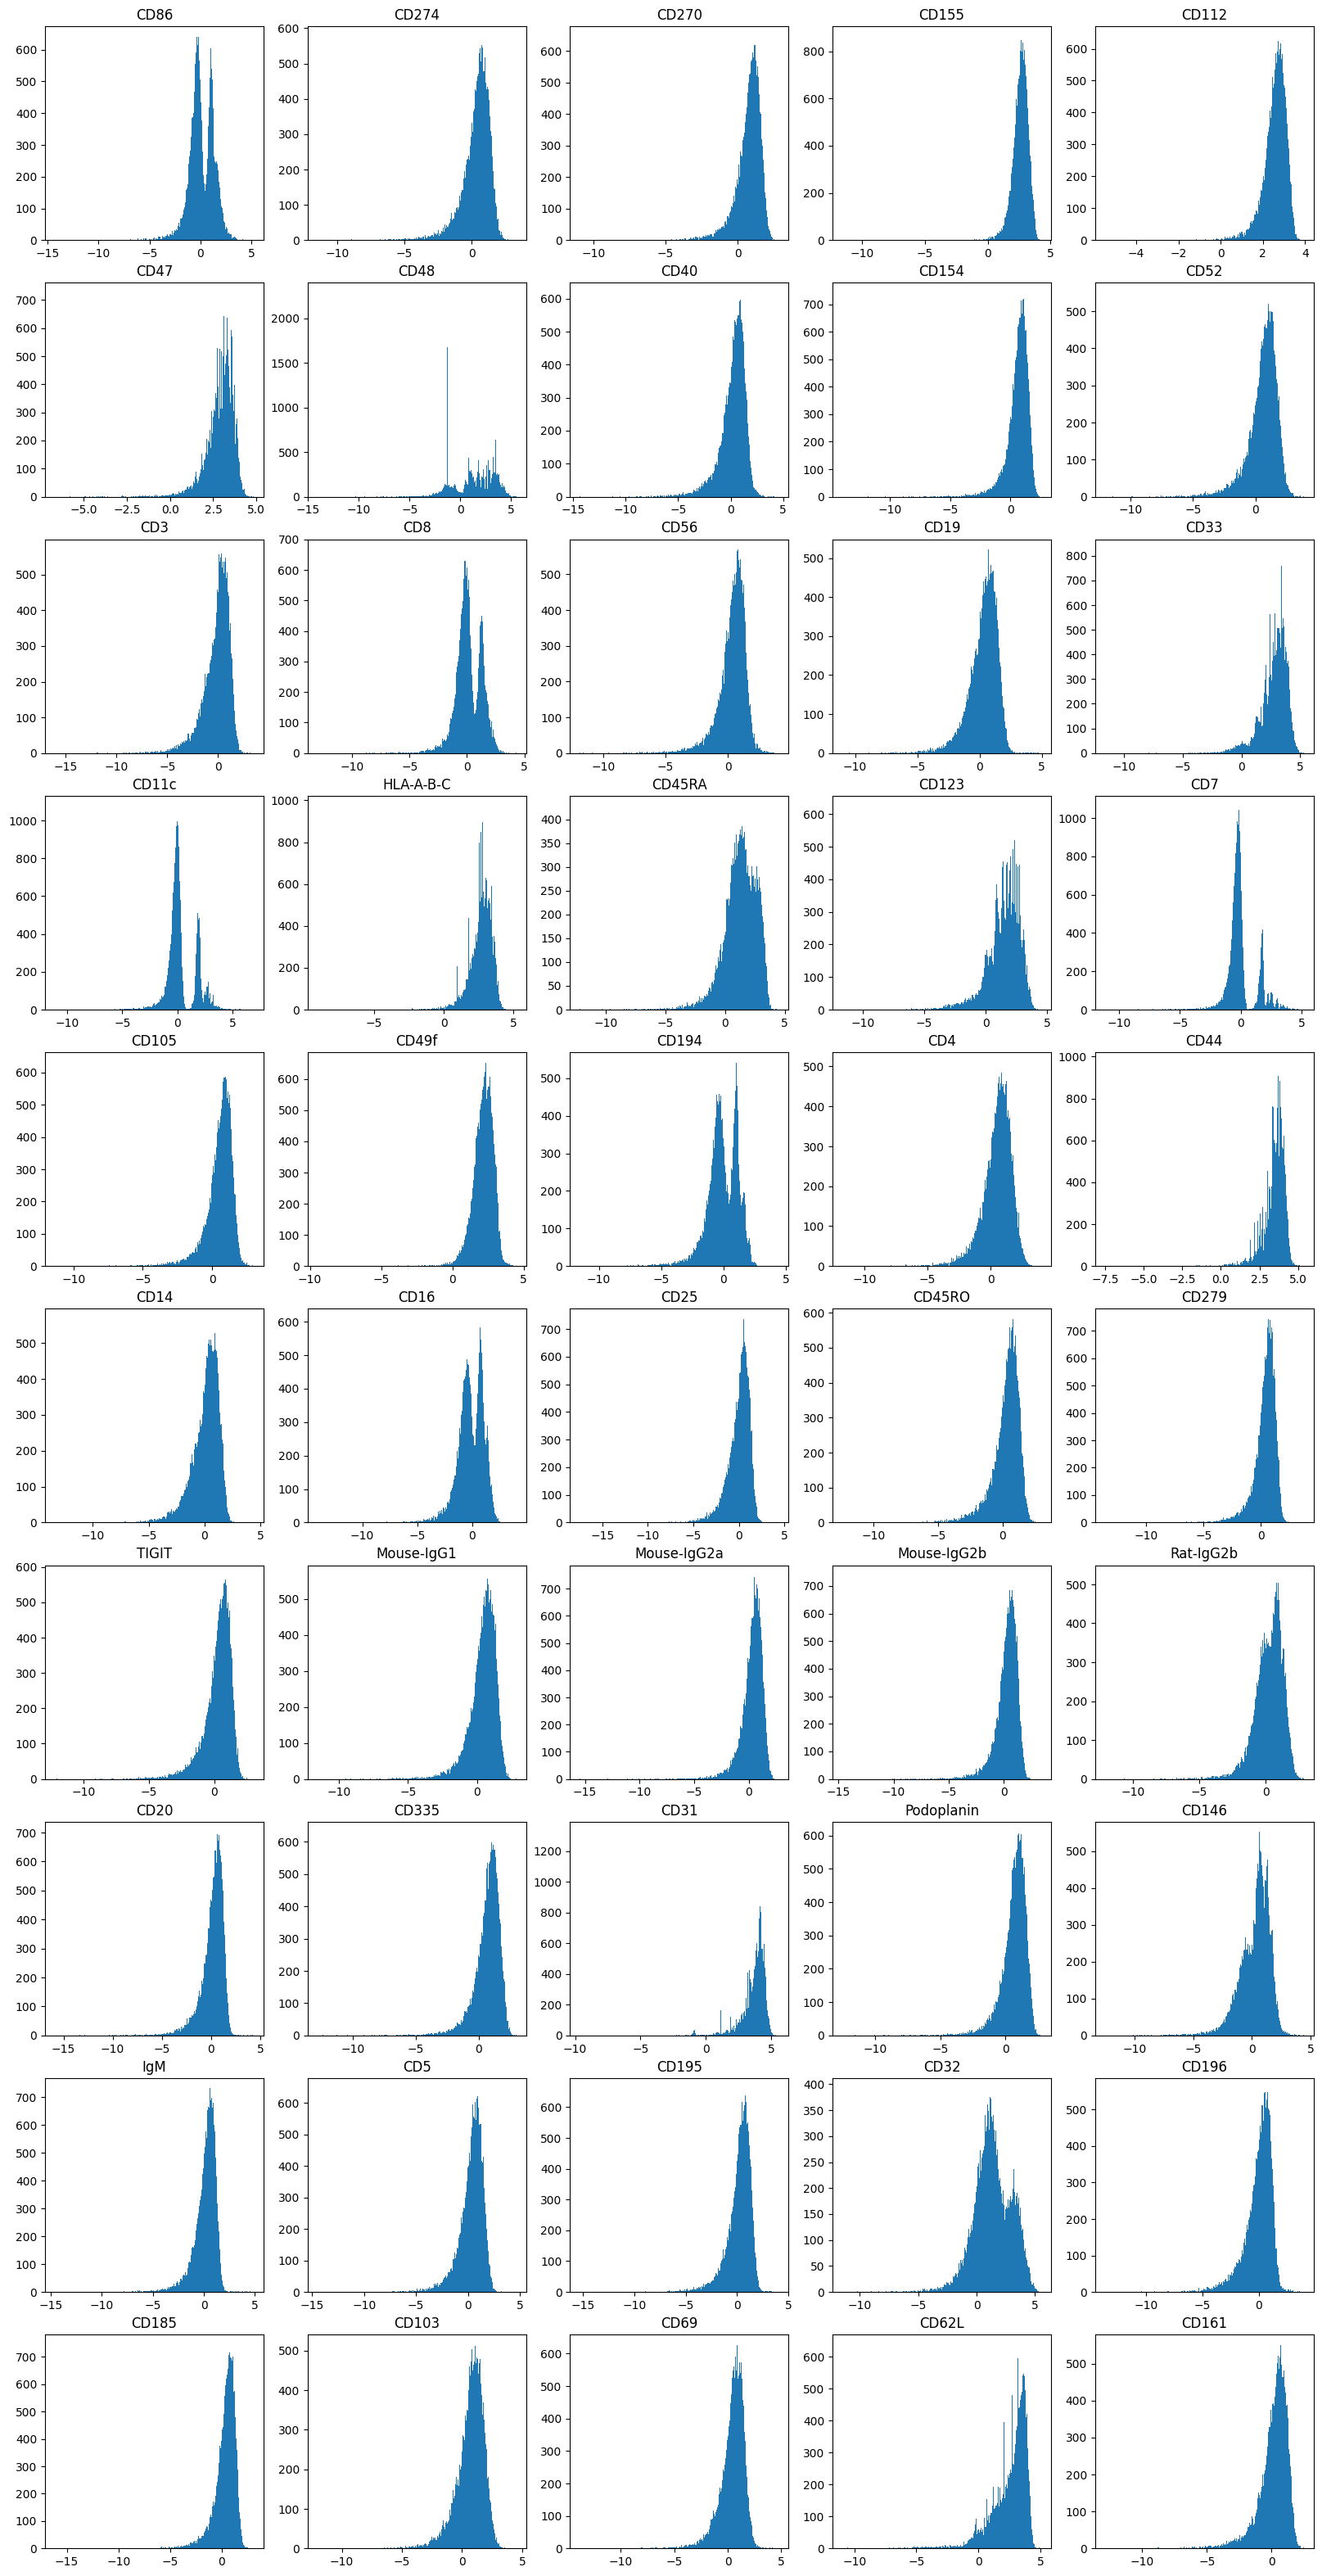

In [9]:
# show the centered log-ratio normalized protein data
# the plots are subplots
fig, axs = plt.subplots(10, 5, figsize=(20, 40))
for i in range(50):
    axs[i//5, i%5].hist(np.log2(cite_train_y[cite_train_y.columns[i]] + 1), bins=1000)
    axs[i//5, i%5].set_title(cite_train_y.columns[i])
plt.show()

So the test should consider the different strategies of normalization of protein and RNA data  
The protein data could be normalized by (log2(x+1) - mean(log2(x+1)) / std(log2(x+1)))  
Or is could be normalized by applying the dsb method  
The RNA data could be normalized by scanpy.pp.normalize_total or scanpy.pp.log1p   
Both of them could be used in the same time or used separately  
Even could use the raw data without normalization for both of them  

# Modeling & Prediction

In [ ]:
params = {
    'learning_rate': 0.5,
    'metric': 'mae',
    'seed': 42,
    'reg_alpha': 0.0014,
    'reg_lambda': 0.2,
    'colsample_bytree': 0.8,
    'subsample': 0.5,
    'max_depth': 12,
    'num_leaves': 722,
    'min_child_samples': 85,
}

model = MultiOutputRegressor(lgb.LGBMRegressor(**params, n_estimators=1000))
print("fitting")
model.fit(cite_train_x, cite_train_y)
print("fit proces done")

y_va_pred = model.predict(cite_train_x)
mse = mean_squared_error(cite_train_y, y_va_pred)
print(mse)
del cite_train_x, cite_train_y
gc.collect()

In [ ]:
cite_test_x = preprocesser.transform(pd.read_hdf(CITE_TEST_INPUTS).values)
test_pred = model.predict(cite_test_x)
del cite_test_x
test_pred.shape

# Gene expression embedding

In [8]:
# %pip install torch
# %pip install einops

In [4]:
import torch
import torch.nn as nn
import torch.functional as F
from einops import rearrange
import numpy as np

In [17]:
x = torch.randn(5,5,5,5)
y = torch.randn(5,5,5,5)

In [19]:
# torch.einsum('b c h w -> b*w c h',x)
torch.einsum('b k h w, b k h w -> b h w', x, y).shape

torch.Size([5, 5, 5])

In [21]:
a = torch.randn(10,20,30) # b -> 10, i -> 20, k -> 30
c = torch.randn(10,50,30) # b -> 10, j -> 50, k -> 30
y1 = torch.einsum('b i k, b j k -> b i j', a , c) # shape [10, 20, 50]
print(y1.shape)

torch.Size([10, 20, 50])


In [27]:
x = torch.randn(10, 100, 1000) # batch, tokens, dim
dim = 1000 ## simulated # of gene
to_qkv = nn.Linear(dim, dim*3, bias=False) ## init qkv matrix
qkv = to_qkv(x) ## x is the gene expression embedding vector
q, k, v = tuple(rearrange(qkv, 'b t (d k) -> k b t d', k=3))
print(q.shape, k.shape, v.shape)

torch.Size([10, 100, 1000]) torch.Size([10, 100, 1000]) torch.Size([10, 100, 1000])


## Original MHSA

In [8]:
# The input dimension of gene expression is (batch, expression, num_hid) (64, 2000, 64)
# The output dimension of multi-head attention is (batch, expression, num_hid)
class multiHeadAtten(nn.Module):
    def __init__(self, num_hid, num_heads=8):
        super().__init__()
        self.num_hid = num_hid
        self.num_heads = num_heads
        self.scale = 1 / (num_hid ** 0.5)
        _dim = num_hid * self.num_heads
        self.to_qkv = nn.Linear(num_hid, _dim * 3, bias=False)
        self.W_o = nn.Linear(_dim, num_hid)
    
    def forward(self, x, mask=None):
        assert x.dim() == 3, 'Input must be (batch size, expression, num_hid)'
        qkv = self.to_qkv(x) # (batch, expression, num_hid * 3)
        q, k, v = tuple(rearrange(qkv, 'b t (d k) -> k b h t d', k=3, h=self.num_heads)) # (batch, num_head ,expression, num_hid)
        scaled_dot_product = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale # (batch, num_head, expression, expression)
        if mask is not None:
            assert mask.shape == scaled_dot_product.shape[1:]
            scaled_dot_product = scaled_dot_product.masked_fill(mask, -1e9)
        attn = torch.softmax(scaled_dot_product, dim=-1) # (batch, num_head, expression, expression)
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v) # (batch, num_head, expression, num_hid)
        out = rearrange(out, 'b h t d -> b t (h d)') # (batch, expression, num_hid * num_head)
        return self.W_o(out) # (batch, expression, num_hid)

class TransformerBlock(nn.Module):
    def __init__(self, num_hid, num_heads, dim_linear=1024, dropout=0.1):
        super().__init__()
        self.num_hid = num_hid
        self.num_heads = num_heads
        self.attn = multiHeadAtten(num_hid, num_heads)
        self.drop = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(num_hid)
        self.norm2 = nn.LayerNorm(num_hid)

        self.linear = nn.Sequential(
            nn.Linear(num_hid, dim_linear),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_linear, num_hid),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        y = self.norm1(self.drop(self.attn(x)) + x)
        return self.norm2(self.linear(y) + y)

class TransformerEncoder(nn.Module):
    def __init__(self, num_hid, num_heads, num_blocks):
        super().__init__()
        self.num_hid = num_hid
        self.num_heads = num_heads
        self.blocks = [TransformerBlock(num_hid, num_heads) for _ in range(num_blocks)]
        self.layers = nn.ModuleList(self.blocks)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
model = TransformerEncoder(64, 8, 6)
print(model)

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerBlock(
      (attn): multiHeadAtten(
        (to_qkv): Linear(in_features=64, out_features=1536, bias=False)
        (W_o): Linear(in_features=512, out_features=64, bias=True)
      )
      (drop): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=64, out_features=1024, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=1024, out_features=64, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerBlock(
      (attn): multiHeadAtten(
        (to_qkv): Linear(in_features=64, out_features=1536, bias=False)
        (W_o): Linear(in_features=512, out_features=64, bias=True)
      )
      (drop): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((64,), eps=1e-05, e

We have already construct CITE-seq training project, but how do we implement integration, which is a two-stream encoder that using both modality information. The input size of transcriptome is 70988 x 240. And the input size of proteome is 70988 x 140. Both of the modality could be interact in the cross attention blocks.

Now let's embedding the features size of transcriptome and proteome into 64, and then implement cross attention.

There are three ways to embed the features size of transcriptome and proteome into 64. The first way is to use the linear layer. The second way is to use the convolutional layer. The third way is to use the PCA or NMF to reduce the dimension of transcriptome and proteome. We will use the first way to implement the embedding. 

In [ ]:
class gene2vec_embedding(nn.Module):
    #(batch, input_dim, hid_dim, output_dim)
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.linearLayer1 = nn.Linear(input_dim, hid_dim)
        self.linearLayer2 = nn.Linear(hid_dim, output_dim)

    def forward(self, x): 
        # x is the gene expression profile, shape (batch, cell, expression)
        # each batch contains multiple cells, each cell contains multiple genes
        # the output of the model is the gene embedding vector
        x = self.linearLayer1(x)
        x = self.linearLayer2(x)
        return x

class protein2vec_embedding(nn.Module):
    # (batch, input_dim, hid_dim, output_dim)
    def __init__(self, input_dim, hid_dim, output_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.linearLayer1 = nn.Linear(input_dim, hid_dim)
        self.linearLayer2 = nn.Linear(hid_dim, output_dim)

    def forward(self, x):
        # x is the protein expression profile, shape (batch, cell, expression)
        # each batch contains multiple cells, each cell contains multiple proteins
        # the output of the model is the protein embedding vector
        x = self.linearLayer1(x)
        x = self.linearLayer2(x)
        return x

## Co-attention

The cross attention block is a two-stream encoder that using both modality information. The input size of transcriptome is (batch size, cell number, feature size), and the input size of proteome is (batch size, cell number, feature size). Both of the modality could be interact in the cross attention blocks.

The loss function has two parts. The 1st part is to calculate the consistency loss between the embedding of transcriptome and proteome. The 2nd part is to calculate the reconstruction loss between the embedding of transcriptome and proteome.

The consistance loss is the loss function that using to calculate the distance between the embedding of transcriptome and proteome. The distance is calculated by the cosine similarity. 

In [ ]:
class two_stream_attention(nn.Module):
    '''
    The two-stream attention model is a model that combines the gene embedding and protein embedding
    to predict the cell type/state. The two-stream attention model has two parts: gene and protein.
    The gene input and protein input are firstly embedded into a vector space, and then the two vectors
    are combined to predict the cell type/state. The gene embedding and protein embedding are both
    implemented by the transformer encoder. The vector will be multiplied by the q, k, v matrix to
    calculate the attention score to gain q_p, k_p, v_p and q_g, k_g, v_g matrices.
    In the cross attention part, the k_p and v_p are used to calculate the weighted sum of the q_g,
    and the k_g and v_g are used to calculate the weighted sum of the q_p. And then the weighted sum 
    of q_g and q_p are separately add&norm and linear&dropout, which are the output of the cross attention.
    The first loss is the cross entropy loss, and the second loss is the cosine similarity loss of the
    output of the cross attention and the ground truth cell type/state. Optionally, the third loss is 
    the masked loss of the output of the cross attention and the ground truth cell type/state. 
    '''
    def __init__(
        self, 
        input_dim: int,
        num_hidden: int = 64,
        num_heads: int = 8,
        dim_linear: int = 1024,
        dropout: float = 0.1
        ):
        '''
        input_dim: the dimension of the input gene and protein expression profile
        num_hidden: the dimension of the embedding vector
        num_heads: the number of heads in the multi-head attention
        '''
        super().__init__()
        self.num_hidden = num_hidden
        self.num_heads = num_heads
        _dim = num_hidden * num_heads
        self.scale = 1 / (num_hidden ** 0.5)
        self.gene2vec = gene2vec_embedding(input_dim, _dim/num_heads, _dim)
        self.protein2vec = protein2vec_embedding(input_dim, _dim/num_heads, _dim)
        self.to_qkv = nn.Linear(num_hidden, _dim * 3, bias=False)
        self.w_g = nn.Linear(_dim, num_hidden)
        self.w_p - nn.Linear(_dim, num_hidden)
        self.drop_g = nn.Dropout(dropout)
        self.norm1_g = nn.LayerNorm(num_hidden)
        self.norm2_g = nn.LayerNorm(num_hidden)
        self.drop_p = nn.Dropout(dropout)
        self.norm1_p = nn.LayerNorm(num_hidden)
        self.norm2_p = nn.LayerNorm(num_hidden)
        self.linear_g = nn.Sequential(
            nn.Linear(num_hidden, dim_linear),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_linear, num_hidden),
            nn.Dropout(dropout)
        )
        self.linear_p = nn.Sequential(
            nn.Linear(num_hidden, dim_linear),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_linear, num_hidden),
            nn.Dropout(dropout)
        )
    
    def forward(self, gene, protein, mask=None):
        gene = self.gene2vec(gene) # (batch, cell, num_hid * num_head)
        protein = self.protein2vec(protein) # (batch, cell, num_hid * num_head)
        qkv_g = self.to_qkv(gene) # (batch, cell, num_hid * num_head * 3)
        qkv_p = self.to_qkv(protein) # (batch, cell, num_hid * num_head * 3)
        # each (batch, num_head, cell, num_hid)
        q_g, k_g, v_g = tuple(rearrange(qkv_g, 'b t (d k) -> k b h t d', k=3, h=self.num_heads)) 
        q_p, k_p, v_p = tuple(rearrange(qkv_p, 'b t (d k) -> k b h t d', k=3, h=self.num_heads))
        # multiply q_g with k_p and v_p to calculate the attention score
        # (batch, num_head, cell, cell)
        scaled_dot_product_g = torch.einsum('b h i d, b h j d -> b h i j', q_g, k_p) * self.scale 
        if mask is not None:
            assert mask.shape == scaled_dot_product_g.shape[1:]
            scaled_dot_product_g = scaled_dot_product_g.masked_fill(mask, -1e9)
        # (batch, num_head, cell, cell)
        attn_g = torch.softmax(scaled_dot_product_g, dim=-1) 
        # (batch, num_head, cell, num_hid)
        out_g = torch.einsum('b h i j, b h j d -> b h i d',attn_g, v_p) 
        # (batch, cell, num_hid * num_head)
        out_g = rearrange(out_g, 'b h t d -> b t (h d)')
        # multiply q_p with k_g and v_g to calculate the attention score
        # (batch, num_head, cell, cell)
        scaled_dot_product_p = torch.einsum('b h i d, b h j d -> b h i j', q_p, k_g) * self.scale
        if mask is not None:
            assert mask.shape == scaled_dot_product_p.shape[1:]
            scaled_dot_product_p = scaled_dot_product_p.masked_fill(mask, -1e9)
        # (batch, num_head, cell, cell)
        attn_p = torch.softmax(scaled_dot_product_p, dim=-1)
        # (batch, num_head, cell, num_hid)
        out_p = torch.einsum('b h i j, b h j d -> b h i d',attn_p, v_g)
        # (batch, cell, num_hid * num_head)
        out_p = rearrange(out_p, 'b h t d -> b t (h d)')
        # (batch, cell, num_hid)     
        out_g = self.w_g(out_g)
        out_p = self.w_p(out_p)
        # 
        out_g = self.norm1_g(self.drop_g(out_g) + gene)
        out_p = self.norm1_p(self.drop_p(out_p) + protein)  
        out_g = self.norm2_g(self.linear_g(out_g) + out_g)
        out_p = self.norm2_p(self.linear_p(out_p) + out_p)
        return out_g, out_p

In [ ]:
class MHSA(nn.Module):
    def __init__(self, num_hid, num_heads=8):
        super().__init__()
        self.num_hid = num_hid
        self.num_heads = num_heads
        self.scale = 1 / (num_hid ** 0.5)
        _dim = num_hid * self.num_heads
        self.to_qkv = nn.Linear(num_hid, _dim * 3, bias=False)
        self.W_o = nn.Linear(_dim, num_hid)
    
    def forward(self, x, mask=None):
        assert x.dim() == 3, 'Input must be (batch size, expression, num_hid)'
        qkv = self.to_qkv(x) # (batch, expression, num_hid * 3)
        q, k, v = tuple(rearrange(qkv, 'b t (d k) -> k b h t d', k=3, h=self.num_heads)) # (batch, num_head ,expression, num_hid)
        scaled_dot_product = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale # (batch, num_head, expression, expression)
        if mask is not None:
            assert mask.shape == scaled_dot_product.shape[1:]
            scaled_dot_product = scaled_dot_product.masked_fill(mask, -1e9)
        attn = torch.softmax(scaled_dot_product, dim=-1) # (batch, num_head, expression, expression)
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v) # (batch, num_head, expression, num_hid)
        out = rearrange(out, 'b h t d -> b t (h d)') # (batch, expression, num_hid * num_head)
        return self.W_o(out) # (batch, expression, num_hid)

class MHSABlock(nn.Module):
    def __init__(self, num_hid, num_heads, dim_linear=1024, dropout=0.1):
        super().__init__()
        self.num_hid = num_hid
        self.num_heads = num_heads
        self.attn = multiHeadAtten(num_hid, num_heads)
        self.drop = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(num_hid)
        self.norm2 = nn.LayerNorm(num_hid)

        self.linear = nn.Sequential(
            nn.Linear(num_hid, dim_linear),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_linear, num_hid),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        y = self.norm1(self.drop(self.attn(x)) + x)
        return self.norm2(self.linear(y) + y)

In [ ]:
class two_stream_transformer_block(nn.Module):
    '''
    The two-stream transformer block based on the two-stream attention mechanism.
    The two-stream transformer block has two parts: gene and protein. The gene input and protein input
    are firstly processed by the MHSA and then the cross-attention followed by the transformer blocks. 
    '''
    def __init__(self, num_hid, num_heads, num_blocks):
        super().__init__()
        self.num_hid = num_hid
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.protein_attn = MHSABlock(num_hid, num_heads)
        self.gene_attn = MHSABlock(num_hid, num_heads)
        self.cross_attn = two_stream_attention(num_hid, num_heads)
        self.protein_attn_blocks = nn.ModuleList([MHSABlock(num_hid, num_heads) for _ in range(num_blocks)])
        self.gene_attn_blocks = nn.ModuleList([MHSABlock(num_hid, num_heads) for _ in range(num_blocks)])
    
    def forward(self, gene, protein, mask=None):
        gene_attn = self.gene_attn(gene)
        protein_attn = self.protein_attn(protein)
        gene_output, protein_output = self.cross_attn(gene_attn, protein_attn, mask)
        for i in range(self.num_blocks):
            gene_output = self.gene_attn_blocks[i](gene_output)
            protein_output = self.protein_attn_blocks[i](protein_output)
        return gene_output, protein_output

In [ ]:
# use the label of the cell for optimization, set the loss function as the cross entropy loss
# In the paper, the loss function is the MSE loss
# With the output of the last layer, calculate the loss function
def loss_fn(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)

# The training process
def train_fn(data_loader, model, optimizer, device):
    model.train()
    for bi, d in enumerate(data_loader):
        gene = d['gene'].to(device, dtype=torch.float)
        protein = d['protein'].to(device, dtype=torch.float)
        targets = d['label'].to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(gene, protein)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        # print the loss value
        if bi % 100 == 0:
            print(f'bi={bi}, loss={loss}')
    # print the loss value
    print(f'Final bi={bi}, loss={loss}')

# The validation process
def eval_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in enumerate(data_loader):
            gene = d['gene'].to(device, dtype=torch.float)
            protein = d['protein'].to(device, dtype=torch.float)
            targets = d['label'].to(device, dtype=torch.long)
            outputs = model(gene, protein)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

# The main function
def run():
    # set the random seed
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    # set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # set the hyperparameters
    EPOCHS = 10
    TRAIN_BATCH_SIZE = 64
    VALID_BATCH_SIZE = 64
    LEARNING_RATE = 3e-4
    NUM_WORKERS = 4
    NUM_BLOCKS = 2
    NUM_HEADS = 8
    NUM_HID = 512

    # load the data
    train_dataset = CellDataset(train_df, gene_features, protein_features)
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=NUM_WORKERS
    )

    valid_dataset = CellDataset(valid_df, gene_features, protein_features)
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=NUM_WORKERS
    )

    # load the model
    model = two_stream_transformer_block(NUM_HID, NUM_HEADS, NUM_BLOCKS)
    model.to(device)

    # set the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # start the training process
    for epoch in range(EPOCHS):
        train_fn(train_data_loader, model, optimizer, device)
        outputs, targets = eval_fn(valid_data_loader, model, device)
        outputs = np.array(outputs) >= 0.5
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f'Epoch={epoch}, Accuracy={accuracy}')

In [ ]:
# use data from the open multi-omics dataset to test the model